# Parsing PPM files
To show how we can mix ASCII and binary data, we have an example where we parse Portable PixMap files (PPM). These files have a small ASCII header and the image itself in binary. The header looks something like this:

```
P6   # this marks the file type in the Netpbm family
640 480
256
<<binary rgb values: 3*w*h bytes>>
```

In [1]:
import numpy as np
from dataclasses import dataclass
from byteparsing import parse_bytes
from byteparsing.parsers import (
    text_literal, integer, eol, named_sequence, sequence, construct,
    tokenize, item, array,  fmap, text_end_by, optional)

The PPM header format allows for comments in the ASCII header.

In [2]:
comment = sequence(text_literal("#"), text_end_by("\n"))

We define a class that should contain all the data in the header.

In [3]:
@dataclass
class Header:
    width: int
    height: int
    maxint: int

Then we can construct a parser for this header, using `named_sequence` and `construct`.

In [4]:
header = named_sequence(
    _1 = tokenize(text_literal("P6")),
    _2 = optional(comment),
    width = tokenize(integer),
    height = tokenize(integer),
    maxint = tokenize(integer)) >> construct(Header)

We'll have to pass on the header information to the parser for the binary blob somehow, so we define a function.

In [5]:
def image_bytes(header: Header):
    shape = (header.height, header.width, 3)
    size = header.height * header.width * 3
    return array(np.uint8, size) >> fmap(lambda a: a.reshape(shape))

ppm_image = header >> image_bytes

Let's test this on a sample image, and ignore the fact that `PIL` has a perfectly good parser for PPM files itself.

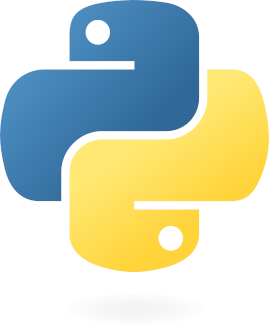

In [6]:
raw_data = open("python-logo.ppm", "rb").read()
image = parse_bytes(ppm_image, raw_data)

from PIL import Image
Image.frombytes(mode="RGB", size=(image.shape[1], image.shape[0]), data=image)